# 02_DiD_estimates.ipynb

In [12]:
from differences import ATTgt
import figure_utilities
import figure_and_table_constants
from matplotlib import pyplot as plt

plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
import numpy as np
import os
import pandas as pd

# Store paths.
INPUT_DATA = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/data/03_cleaned/restricted.csv"
OUTPUT_FIGURES = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/output/DiD/figures"
OUTPUT_TABLES = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/output/DiD/tables"

# Read restricted sample panel dataset into memory.
df = pd.read_csv(INPUT_DATA)

/var/folders/lm/j45l41m16cs8sd5r9sh4gj6w0000gn/T/ipykernel_93145/4103288877.py:18: DtypeWarning: Columns (149,151) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_DATA)


In [13]:
# Store a list of column names containing Zestimates.
years = [str(year) for year in range(2013, 2023)]
months = ["0" + str(month) for month in range(1, 10)] + [str(month) for month in range(10, 13)]
value_vars = ["2012-12"] + [str(year) + "-" + str(month) for year in years for month in months]

# Create dictionaries to map between string represetation and integer representation of each month.
month_to_int_dictionary = {key: value for value, key in enumerate(value_vars)}
int_to_month_dictionary = {key: value for key, value in enumerate(value_vars)}

# Drop rows for which we are missing any Zestimates.
has_all_zestimates_mask = df[value_vars].notna().all(axis=1)
print(f"Limiting sample to {has_all_zestimates_mask.sum()} evictions for which we observe Zestimates at every month "
      "from 2012-12 to 2022-12.")
df = df.loc[has_all_zestimates_mask, :]

Limiting sample to 3298 evictions for which we observe Zestimates at every month from 2012-12 to 2022-12.


In [14]:
# Store treatment date variable -- may be either file_date or latest_docket_date -- and drop rows where missing.
treatment_date_variable = 'file_date'
treatment_year_variable = treatment_date_variable.replace("date", "year")
treatment_month_variable = treatment_date_variable.replace("date", "month")
df = df.dropna(subset='latest_docket_date')
print(f"Limiting sample to {len(df)} evictions for which we observe the latest docket date.")

# Reshape from wide to long.
cases_per_year = df[treatment_year_variable].value_counts()
df = pd.melt(df,
             id_vars=['case_number', treatment_date_variable, 'judgment_for_plaintiff'],
             value_vars=value_vars, var_name='month', value_name='zestimate')
df = df.sort_values(by=['case_number', 'month'])

# Get 'first treated' date for each observation.
df.loc[:, treatment_month_variable] = pd.to_datetime(df[treatment_date_variable]).dt.strftime('%Y-%m')
df.loc[:, treatment_year_variable] = pd.to_datetime(df[treatment_date_variable]).dt.strftime('%Y')

# Convert months from string format to integer format.
df.loc[:, 'month'] = df['month'].replace(month_to_int_dictionary)
df.loc[:, treatment_month_variable] = df[treatment_month_variable].replace(month_to_int_dictionary)
never_treated_mask = (df['judgment_for_plaintiff'] == 0)
df.loc[never_treated_mask, treatment_month_variable] = np.NaN
df.loc[never_treated_mask, treatment_year_variable] = np.NaN

# Set index to entity and time.
df = df.set_index(['case_number', 'month'])

Limiting sample to 2964 evictions for which we observe the latest docket date.


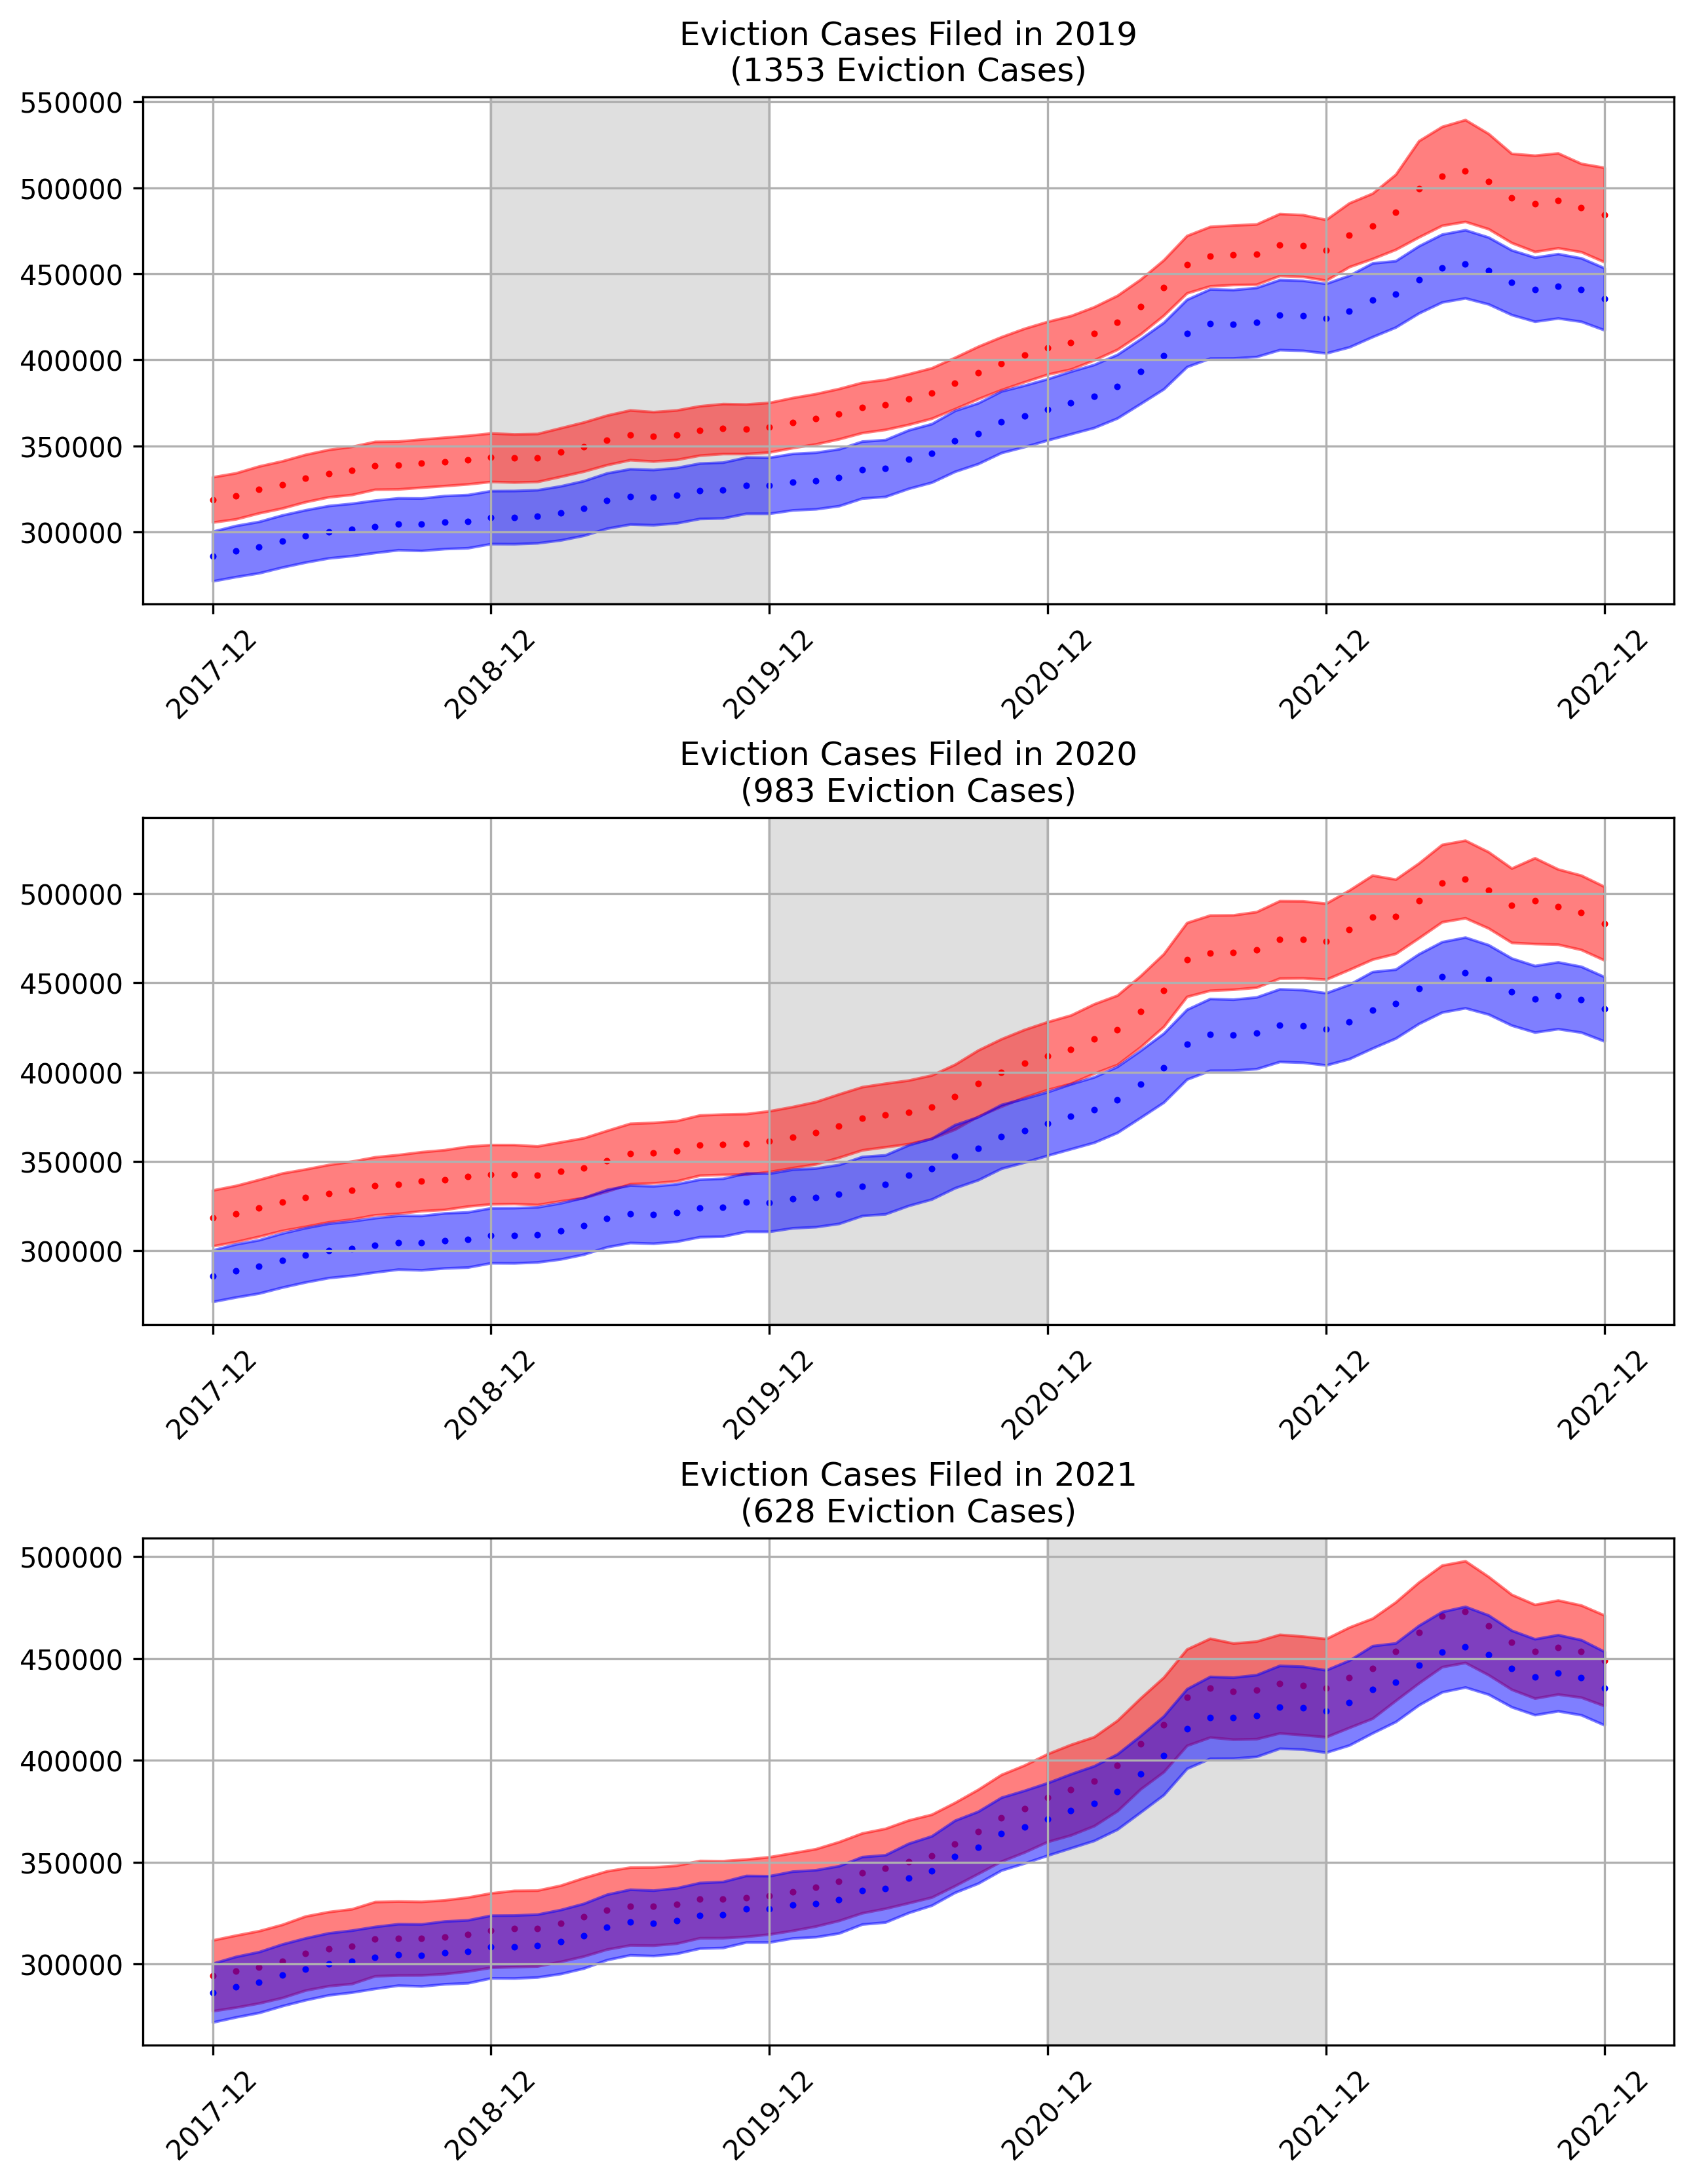

In [15]:
# Plot path of outcomes in treated group vs. control group, separately by year of filing.
# Plot.
aggregated_zestimates = (df
                         .copy().loc[(slice(None), slice(60, 120)), ]
                         .groupby([treatment_year_variable, 'month'], dropna=False)['zestimate']
                         .agg([np.mean, np.std, 'count']))
aggregated_zestimates.loc[:, 'se'] = aggregated_zestimates['std'] / np.sqrt(aggregated_zestimates['count'])
aggregated_zestimates.loc[:, 'y_upper'] = aggregated_zestimates['mean'] + 1.96 * aggregated_zestimates['se']
aggregated_zestimates.loc[:, 'y_lower'] = aggregated_zestimates['mean'] - 1.96 * aggregated_zestimates['se']
treatment_times = aggregated_zestimates.index.get_level_values(treatment_year_variable).unique()

fig, axes = plt.subplots(3, 1, layout='constrained', figsize=(8.5, 11))
for ax, aggregated_cohort in zip(axes, treatment_times):
    # Shade months during which treatment occurred in each aggregated cohort.
    start_shading = 12*(int(aggregated_cohort) - 2017 - 1)
    end_shading = start_shading + 12
    ax.axvspan(start_shading, end_shading, color=figure_and_table_constants.Colors.LABELING_COLOR,
               alpha=0.25)
    sub_df_treatment = aggregated_zestimates.loc[aggregated_cohort, :]
    count_treatment = sub_df_treatment['count'].sum()
    y_treatment = sub_df_treatment['mean'].values
    x_treatment = pd.Series(sub_df_treatment.index.get_level_values('month')).replace(int_to_month_dictionary).values
    y_upper_treatment = sub_df_treatment['y_upper'].values
    y_lower_treatment = sub_df_treatment['y_lower'].values

    figure_utilities.plot_scatter_with_shaded_errors(ax,
                                                     x_treatment,
                                                     y_treatment,
                                                     y_upper_treatment,
                                                     y_lower_treatment,
                                                     point_color=figure_and_table_constants.Colors.TREATMENT_COLOR,
                                                     error_color=figure_and_table_constants.Colors.TREATMENT_COLOR)

    sub_df_control = (aggregated_zestimates.loc[aggregated_zestimates.index.get_level_values(treatment_year_variable)
                                                .isna(), :])
    count_control = sub_df_control['count'].sum()
    y_control = sub_df_control['mean'].values
    x_control = pd.Series(sub_df_control.index.get_level_values('month')).replace(int_to_month_dictionary).values
    y_upper_control = sub_df_control['y_upper'].values
    y_lower_control = sub_df_control['y_lower'].values
    figure_utilities.plot_scatter_with_shaded_errors(ax,
                                                     x_control,
                                                     y_control,
                                                     y_upper_control,
                                                     y_lower_control,
                                                     point_color=figure_and_table_constants.Colors.CONTROL_COLOR,
                                                     error_color=figure_and_table_constants.Colors.CONTROL_COLOR)
    ax.set_xticks(range(0, len(x_treatment), 12))
    ax.grid(True)


    ax.tick_params(axis='x', labelrotation=45)
    if treatment_date_variable == 'file_date':
        verb = 'Filed'
    elif treatment_date_variable == 'latest_docket_date':
        verb = 'Concluded'
    else:
        raise ValueError("Invalid treatment_date_variable.")
    ax.set_title(f"Eviction Cases {verb} in {aggregated_cohort}\n"
                 f"({cases_per_year.loc[int(aggregated_cohort)]} Eviction Cases)")
plt.show()
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "trends_in_zestimates_by_cohort.png"))

In [16]:
# Run DiD.
att_gt = ATTgt(data=df, cohort_name=treatment_month_variable, freq='M')
result = att_gt.fit(formula='zestimate', control_group='never_treated', n_jobs=-1)

Computing ATTgt [workers=10]  100%|████████████████████| 3000/3000 [01:17<00:00, 38.57it/s]


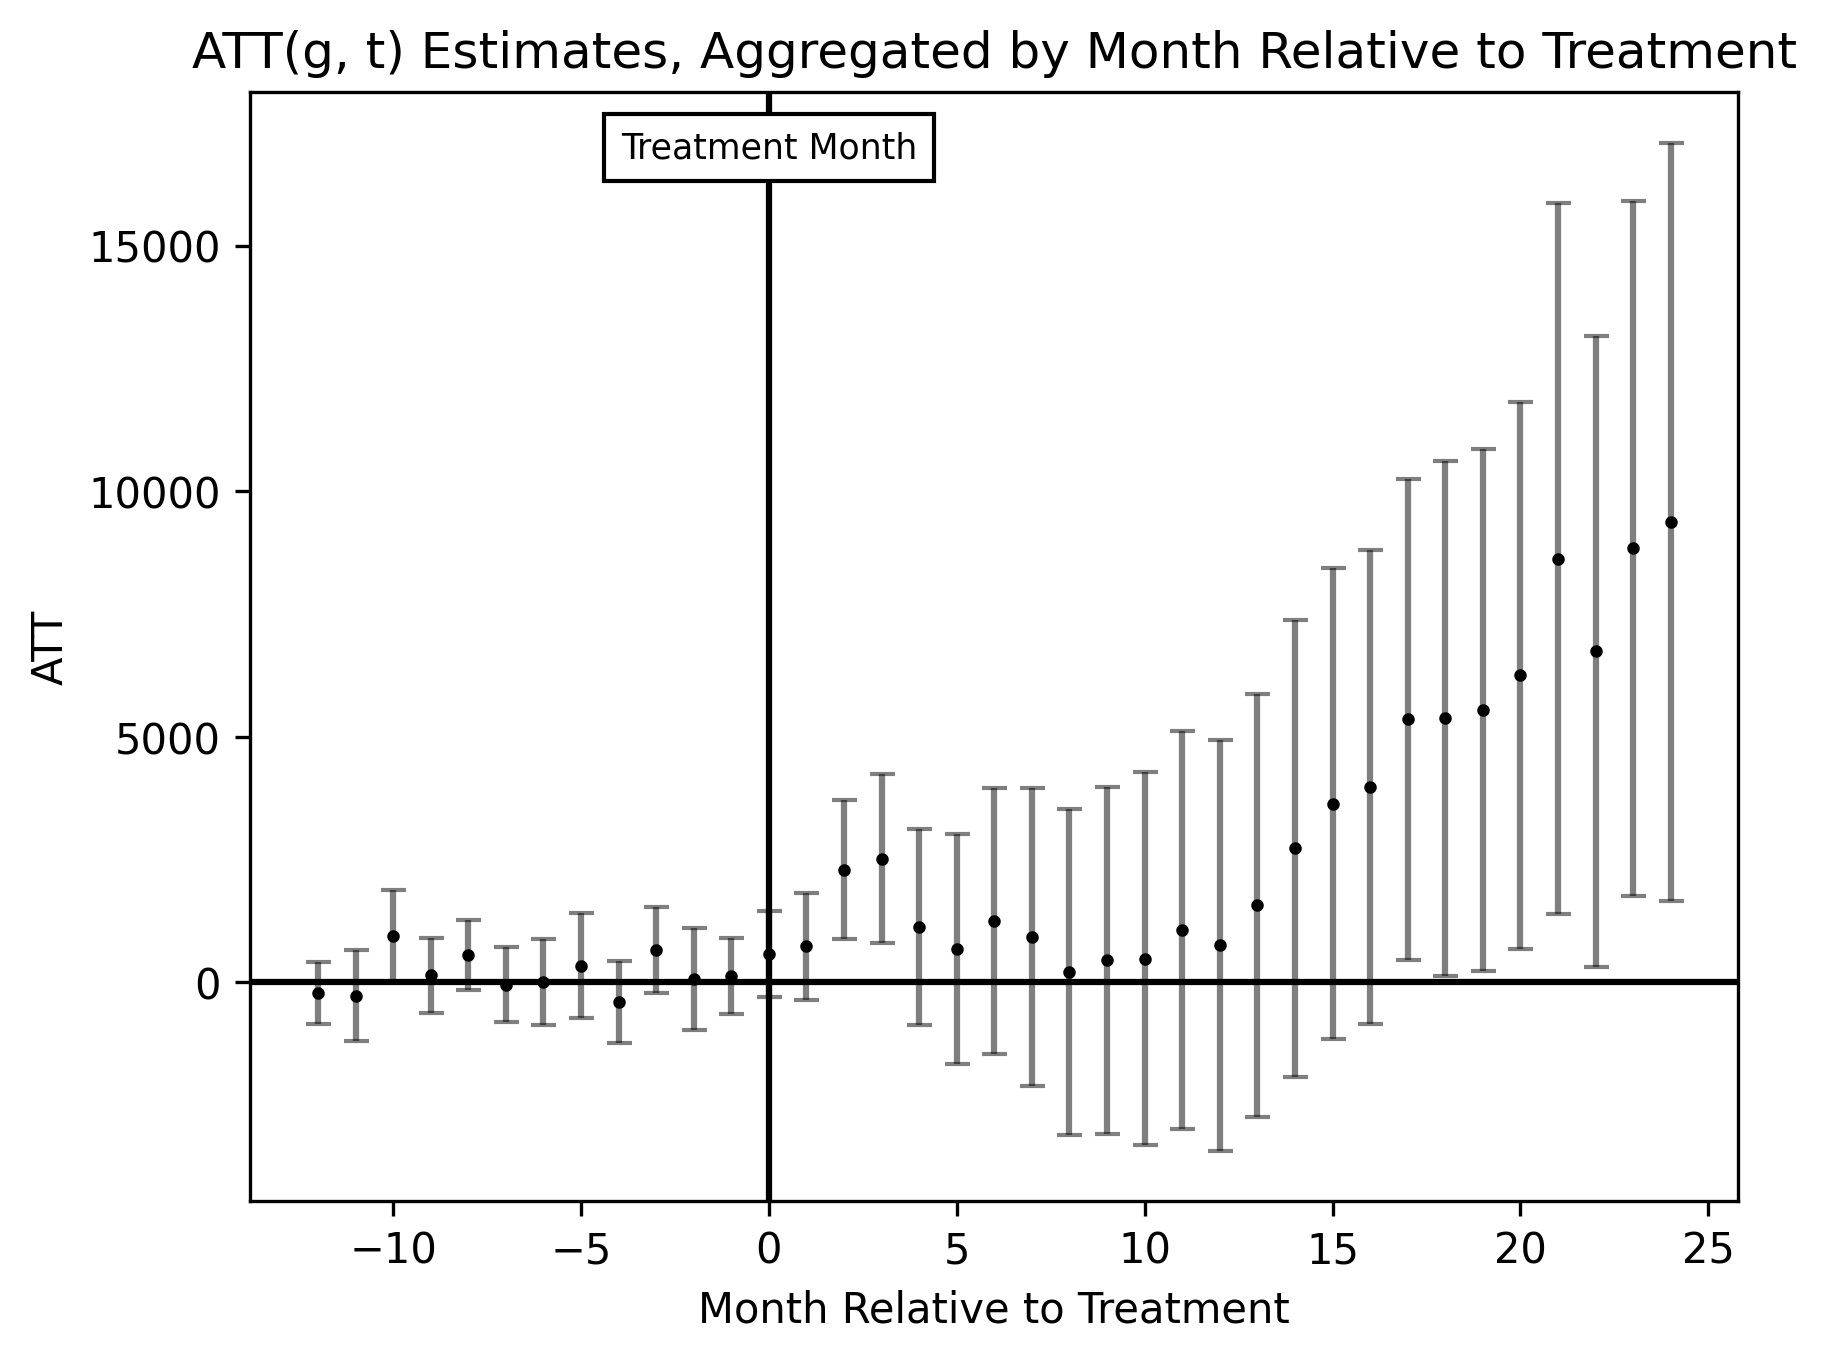

In [17]:
# Get cohort-aggregated ATT(t)s.
results_df = att_gt.aggregate('event')
results_df = results_df.loc[-12:24]
results_df.columns = results_df.columns.droplevel().droplevel()

# Plot event study-style plot of ATTs.
fig, ax = plt.subplots()
x = results_df.index
y = results_df['ATT']
y_upper = results_df['upper']
y_lower = results_df['lower']
ax.set_xlabel("Month Relative to Treatment")
ax.set_ylabel("ATT")
ax.set_title("ATT(g, t) Estimates, Aggregated by Month Relative to Treatment")
figure_utilities.plot_labeled_vline(ax, x=0, text="Treatment Month", color='black', linestyle='-',
                                    text_y_location_normalized=0.95)
figure_utilities.plot_labeled_hline(ax, y=0, text="", color='black', linestyle='-')
figure_utilities.plot_scatter_with_error_bars(ax,
                                              x,
                                              y,
                                              y_upper,
                                              y_lower,
                                              point_color='black',
                                              error_color='black')
plt.show()
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "att_gt_estimates_event_study.png"))
